In [2]:
import pandas as pd

train_data = pd.read_csv('../data/train.csv')
train_data.shape

(14409, 2401)

In [3]:
X_train, y_train = train_data.drop('Class', axis=1), train_data['Class']
print(X_train)
print(y_train)

            x1      y1  xVel1  yVel1   xA1   yA1   xS1   yS1   xC1   yC1  ...  \
0      -665.32 -307.31  -8.35  -0.17 -0.56 -0.02  0.00  0.00 -0.32 -0.04  ...   
1       741.37  895.65   8.05  13.52  0.00  1.00  2.75  1.71  0.00  0.00  ...   
2      -255.72 -934.51 -11.62  -4.70  0.00  0.00  0.00  0.00  0.00  0.00  ...   
3       295.64  913.03   0.02  11.30 -0.17  1.03  0.97 -3.88  0.00  0.00  ...   
4       975.62 -133.05  -0.30   8.19 -0.04  1.00  0.00  0.00 -0.04  1.00  ...   
...        ...     ...    ...    ...   ...   ...   ...   ...   ...   ...  ...   
14404   258.90 -697.48 -12.69   0.00  1.00  0.10 -1.77  0.50 -1.22 -2.38  ...   
14405   972.02 -290.78  -7.05  -0.92 -0.99 -0.15  0.00  0.00 -1.00  0.05  ...   
14406  1353.72 -529.07   1.21   8.21 -0.01  1.00  0.00  0.00  0.35  0.94  ...   
14407  -981.55 -624.82 -14.96  -6.05  0.00  0.00  0.00  0.00  0.00  0.00  ...   
14408   144.76  280.85  -9.32  -2.19 -0.98 -0.21  0.00  0.00 -0.98 -0.19  ...   

       xVel200  yVel200  xA

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train, y_train)
X_scaled

array([[-0.90806221, -0.41188536, -1.17614539, ...,  0.01711812,
         0.15636752, -0.28972054],
       [ 0.76154574,  1.69288541,  1.3788869 , ..., -0.1289564 ,
        -0.48501791, -0.28972054],
       [-0.42190576, -1.509272  , -1.68559391, ..., -0.1289564 ,
        -0.31009461, -0.28972054],
       ...,
       [ 1.48834725, -0.79988992,  0.31325148, ..., -0.1289564 ,
        -0.77655674, -0.28972054],
       [-1.2833973 , -0.96741985, -2.20594804, ..., -0.1289564 ,
         0.06890587, -0.28972054],
       [ 0.05342611,  0.61719456, -1.32726621, ...,  0.17942313,
        -0.74740286, -0.28972054]])

In [5]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=0.5)
X_vt = vt.fit_transform(X_scaled)
X_vt.shape, vt.get_support().sum()

((14409, 2400), np.int64(2400))

In [6]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

mi = SelectKBest(score_func=mutual_info_classif, k=100)
X_mi = mi.fit_transform(X_vt, y_train)

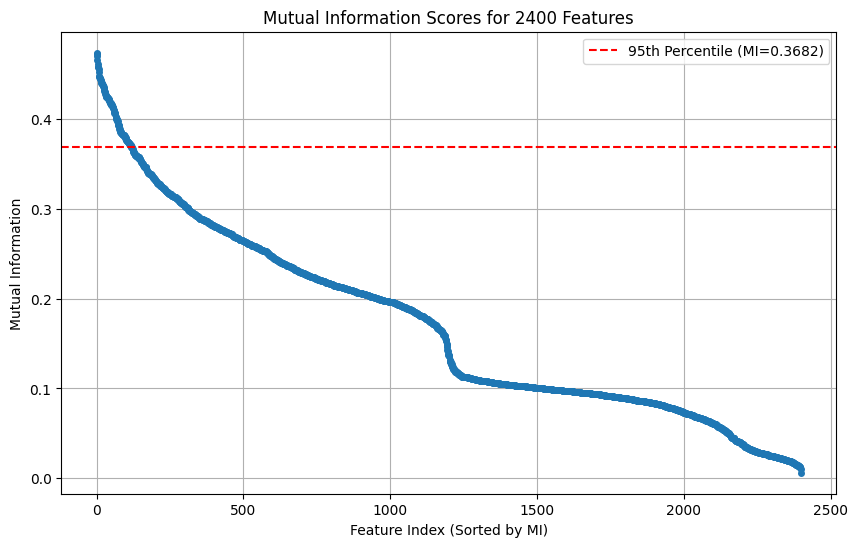

Number of features: 2400
Max MI: 0.4736
Min MI: 0.0063
95th Percentile MI: 0.3682


In [7]:
import numpy as np
import matplotlib.pyplot as plt

sorted_mi = np.sort(mi.scores_)[::-1]
indices = np.arange(len(sorted_mi))

plt.figure(figsize=(10, 6))
plt.plot(indices, sorted_mi, marker='o', linestyle='-', markersize=4)
plt.xlabel("Feature Index (Sorted by MI)")
plt.ylabel("Mutual Information")
plt.title("Mutual Information Scores for 2400 Features")
plt.grid(True)

threshold = np.percentile(sorted_mi, 95)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'95th Percentile (MI={threshold:.4f})')
plt.legend()

plt.show()

print(f"Number of features: {len(sorted_mi)}")
print(f"Max MI: {np.max(sorted_mi):.4f}")
print(f"Min MI: {np.min(sorted_mi):.4f}")
print(f"95th Percentile MI: {threshold:.4f}")

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin

# Custom correlation filter
class CorrelationThreshold(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1.0):
        self.threshold = threshold
        self.selected_features_ = None
        self.scores_ = None
        self.mask_ = None

    def fit(self, X, y=None):
        corr_matrix = np.abs(np.corrcoef(X, rowvar=False))
        self.scores_ = corr_matrix
        self.selected_features_ = np.arange(X.shape[1])
        keep_features = []
        for i in range(X.shape[1]):
            if i in self.selected_features_:
                keep_features.append(i)
                correlated_features = np.where(corr_matrix[i] > self.threshold)[0]
                self.selected_features_ = np.setdiff1d(self.selected_features_, correlated_features)
        self.selected_features_ = np.array(keep_features)
        mask = np.zeros(X.shape[1], dtype=bool)
        mask[self.selected_features_] = True
        self.mask_ = mask
        return self

    def transform(self, X):
        return X[:, self.selected_features_]

    def get_support(self):
        return self.mask_

In [89]:
ct = CorrelationThreshold(threshold=0.7)
X_ct = ct.fit_transform(X_mi)
print(f'Number of remaining features:{ct.get_support().sum()}')
print(f'Selected features (index):\n{ct.selected_features_}')
print(f'Correlation scores:\n{ct.scores_}')

Number of remaining features:206
Selected features (index):
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  19  20  21  22  23  25  27  28  30  31  33  34  35  36  37  39  41  42
  43  44  47  48  49  50  51  52  53  55  57  58  60  61  62  64  66  67
  68  69  70  71  72  73  76  78  79  80  81  82  83  84  86  87  88  89
  91  92  94  95  96  97 100 102 103 104 105 106 108 109 110 111 112 114
 115 116 117 118 119 120 122 123 124 126 130 133 134 135 136 138 139 140
 144 145 147 149 151 152 153 156 159 160 161 162 163 165 167 168 171 172
 174 176 177 180 181 182 184 186 187 188 191 192 194 195 196 200 201 203
 204 206 210 211 212 213 214 215 216 218 222 223 224 225 227 229 230 231
 233 234 235 236 237 238 239 243 244 245 246 248 249 250 252 255 256 257
 259 260 261 263 264 267 269 270 271 275 276 277 278 279 280 281 285 286
 287 290 291 293 294 296 298 299]
Correlation scores:
[[1.         0.1636436  0.32153664 ... 0.24194589 0.22235023 0.19856368]
 [0.163643

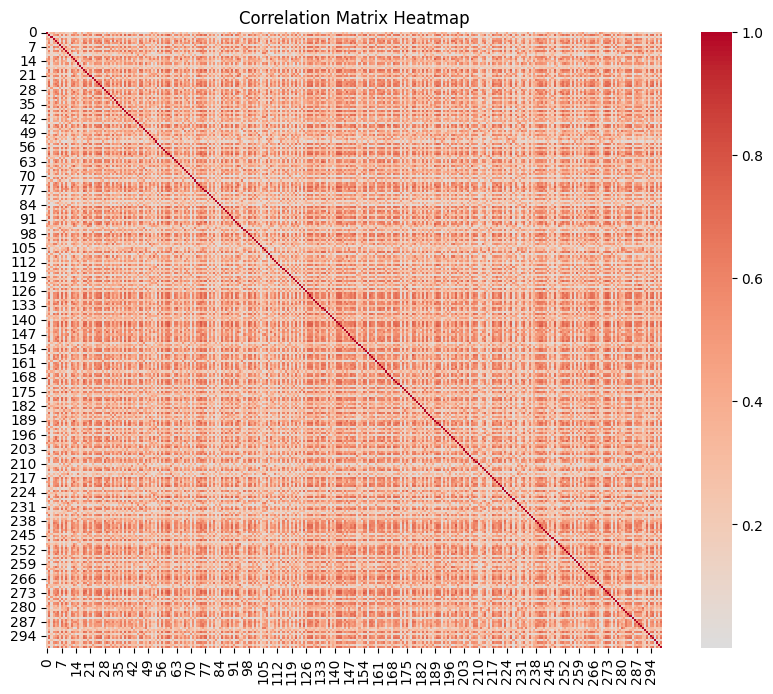

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(ct.scores_, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()